## Publicly available datasets

UCI Machine Learning Repository: This is a collection of almost 300 datasets of various types and sizes for tasks including classification, regression, clustering, and recommender systems. The list is available at http://archive.ics.uci.edu/ml/.

Amazon AWS public datasets: This is a set of often very large datasets that can be accessed via Amazon S3. These datasets include the Human Genome Project, the Common Crawl web corpus, Wikipedia data, and Google Books Ngrams. Information on these datasets can be found at http://aws.amazon.com/publicdatasets/.

Kaggle: This is a collection of datasets used in machine learning competitions run by Kaggle. Areas include classification, regression, ranking, recommender systems, and image analysis. These datasets can be found under the Competitions section at http://www.kaggle.com/competitions.

KDnuggets: This has a detailed list of public datasets, including some of those mentioned earlier. The list is available at http://www.kdnuggets.com/datasets/index.html.

In [5]:
%pylab inline
# %matplotlib notebook
# import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Exploring the User Dataset

You can download the dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip.

In [1]:
from pyspark import SparkContext
sc = SparkContext("local[*]", "MovieLens")

First, we will analyze the characteristics of MovieLens users

In [2]:
# replace this PATH with the correct path to the MovieLens dataset on your computer
PATH = "/home/rafalpa/BIGDATA/examples/spark/notebooks/data"
user_data = sc.textFile("%s/ml-100k/u.user" % PATH)
user_data.first()

'1|24|M|technician|85711'

Let's transform the data by splitting each line, around the "|" character. This will give us an RDD where each record is a Python list that contains the user ID, age, gender, occupation, and ZIP code fields.

We will then count the number of users, genders, occupations, and ZIP codes. 

In [3]:
user_fields = user_data.map(lambda line: line.split("|"))
num_users = user_fields.map(lambda fields: fields[0]).count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()
print ("Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % (num_users, num_genders, num_occupations, num_zipcodes))

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


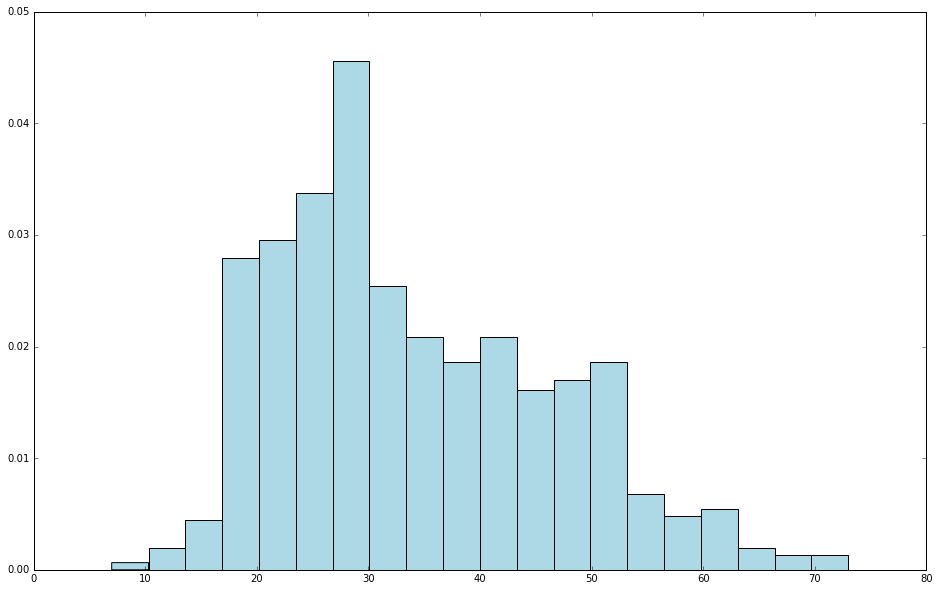

In [6]:
ages = user_fields.map(lambda x: int(x[1])).collect()
hist(ages, bins=20, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

We might also want to explore the relative frequencies of the various occupations of our users. We can do this using the following code snippet. First, we will use the MapReduce approach introduced previously to count the occurrences of each occupation in the dataset. Then, we will use matplotlib to display a bar chart of occupation counts, using the bar function.

Since part of our data is the descriptions of textual occupation, we will need to manipulate it a little to get it to work with the bar function:

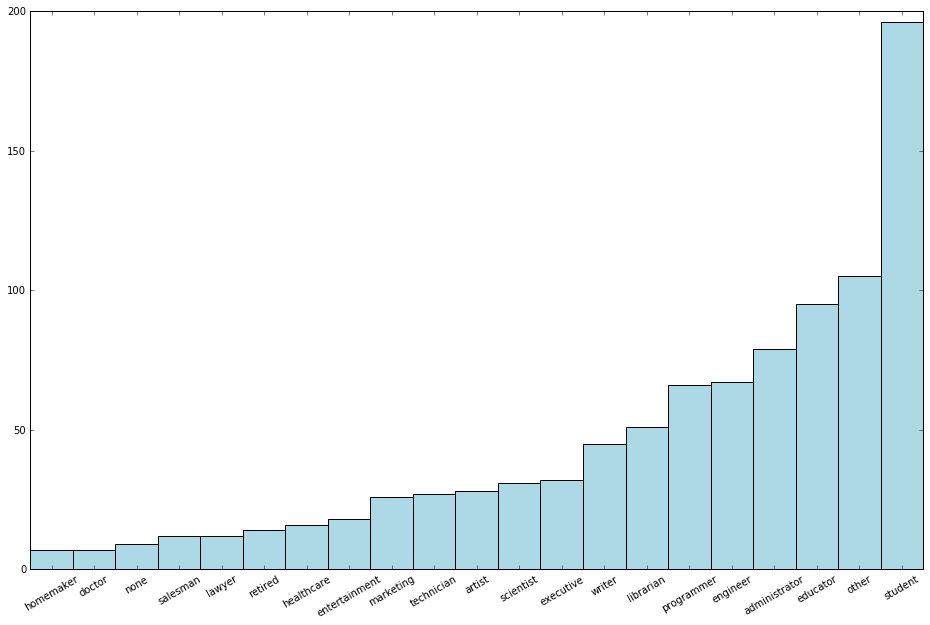

In [7]:
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [8]:
# Note we can also use the Spark RDD method 'countByValue' to generate the occupation counts
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print ("Map-reduce approach:")
print (dict(count_by_occupation2))
print ("")
print ("countByValue approach:")
print (dict(count_by_occupation))

Map-reduce approach:
{'retired': 14, 'salesman': 12, 'other': 105, 'programmer': 66, 'none': 9, 'artist': 28, 'marketing': 26, 'educator': 95, 'administrator': 79, 'scientist': 31, 'student': 196, 'doctor': 7, 'executive': 32, 'writer': 45, 'lawyer': 12, 'engineer': 67, 'technician': 27, 'librarian': 51, 'healthcare': 16, 'homemaker': 7, 'entertainment': 18}

countByValue approach:
{'student': 196, 'retired': 14, 'librarian': 51, 'salesman': 12, 'executive': 32, 'other': 105, 'writer': 45, 'lawyer': 12, 'engineer': 67, 'programmer': 66, 'educator': 95, 'none': 9, 'artist': 28, 'healthcare': 16, 'technician': 27, 'marketing': 26, 'homemaker': 7, 'doctor': 7, 'administrator': 79, 'scientist': 31, 'entertainment': 18}


## Exploring the Movie Dataset

Next, we will investigate a few properties of the movie catalogue. We can inspect a row of the movie data file, as we did for the user data earlier, and then count the number of movies:

In [9]:
movie_data = sc.textFile("%s/ml-100k/u.item" % PATH)
print (movie_data.first())
num_movies = movie_data.count()
print ("Movies: %d" % num_movies)

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


In [13]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 # there is a 'bad' data point with a blank year, which we set to 1900 and will filter out later

movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
# we filter out any 'bad' data points here
years_filtered = years.filter(lambda x: x != 1900)
# plot the movie ages histogram
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = list(movie_ages.values())
bins = list(movie_ages)#

This is a good example of how real-world datasets can often be messy and require a more in-depth approach to parsing data. In fact, this also illustrates why data exploration is so important, as many of these issues in data integrity and quality are picked up during this phase.

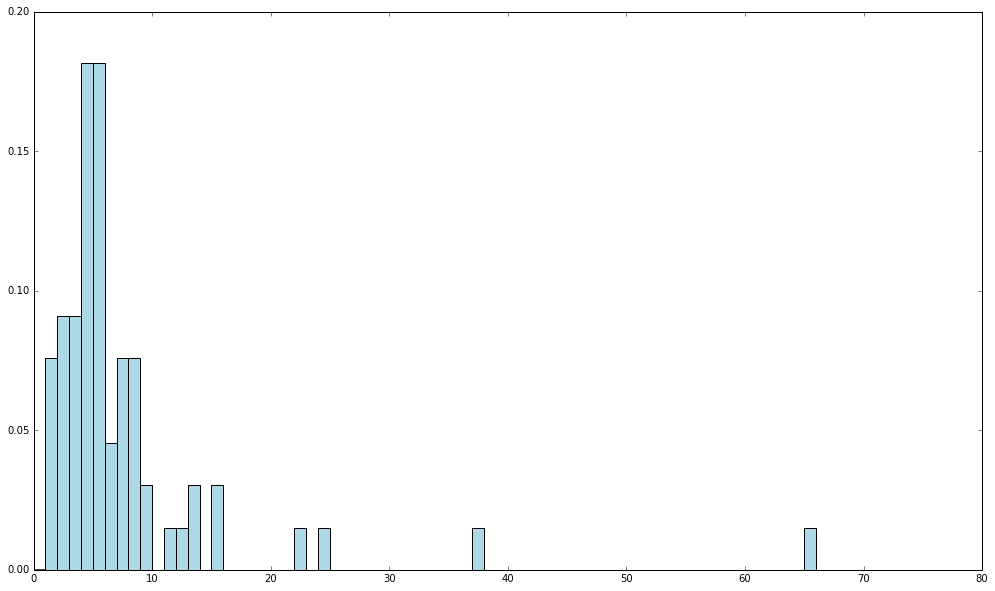

In [15]:
plt.hist(values, bins=bins, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(17,10)

## Exploring the Rating Dataset

In [16]:
rating_data_raw = sc.textFile("%s/ml-100k/u.data" % PATH)
print (rating_data_raw.first())
num_ratings = rating_data_raw.count()
print ("Ratings: %d" % num_ratings)

196	242	3	881250949
Ratings: 100000


In [17]:
rating_data = rating_data_raw.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print ("Min rating: %d" % min_rating)
print ("Max rating: %d" % max_rating)
print ("Average rating: %2.2f" % mean_rating)
print ("Median rating: %d" % median_rating)
print ("Average # of ratings per user: %2.2f" % ratings_per_user)
print ("Average # of ratings per movie: %2.2f" % ratings_per_movie)

Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4
Average # of ratings per user: 106.04
Average # of ratings per movie: 59.45


In [18]:
# we can also use the stats function to get some similar information to the above
ratings.stats()

(count: 100000, mean: 3.5298599999999967, stdev: 1.1256679707622512, max: 5.0, min: 1.0)

Looking at the results, the average rating given by a user to a movie is around 3.5 and the median rating is 4, so we might expect that the distribution of ratings will be skewed towards slightly higher ratings. Let's see whether this is true by creating a bar chart of rating values using a similar procedure as we did for occupations:

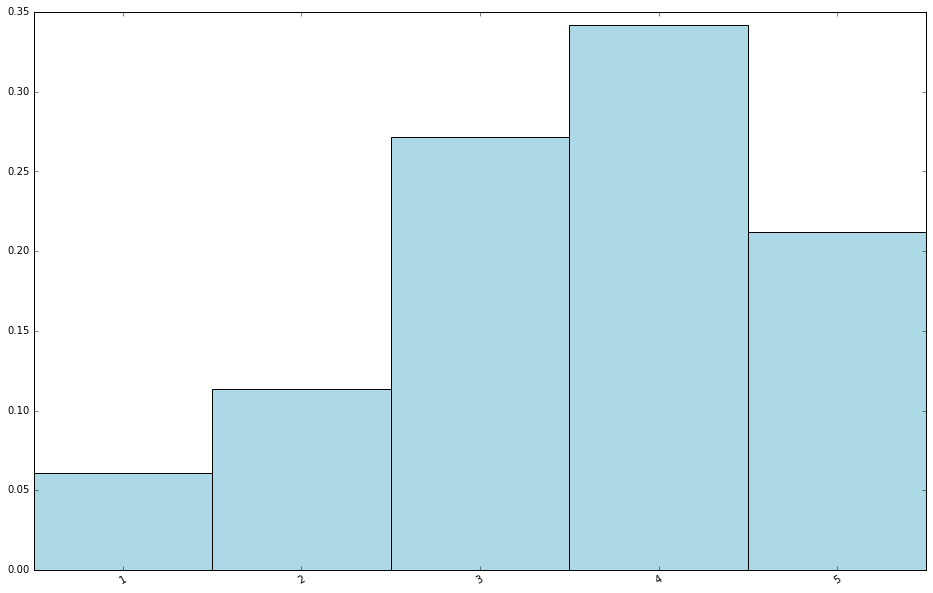

In [26]:
# create plot of counts by rating value
count_by_rating = ratings.countByValue()
x_axis = np.array(list(count_by_rating.keys()))
y_axis = np.array([float(c) for c in count_by_rating.values()])
# we normalize the y-axis here to percentages
y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(len(list(x_axis)))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [28]:
list(count_by_rating.values())

[6110, 11370, 27145, 34174, 21201]

In [29]:
count_by_rating

defaultdict(int, {1: 6110, 2: 11370, 3: 27145, 4: 34174, 5: 21201})

In [30]:
list(count_by_rating)

[1, 2, 3, 4, 5]

In [38]:
# to compute the distribution of ratings per user, we first group the ratings by user id
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))). \
    groupByKey() 
# then, for each key (user id), we find the size of the set of ratings, which gives us the # ratings for that user 
user_ratings_byuser = user_ratings_grouped.map(lambda kv: (kv[0], len(kv[1])))#map(lambda (k, v): (k, len(v)))
user_ratings_byuser.take(5)

[(2, 62), (4, 24), (6, 211), (8, 59), (10, 184)]

We can see that most of the users give fewer than 100 ratings. The distribution of the ratings shows, however, that there are fairly large number of users that provide hundreds of ratings.

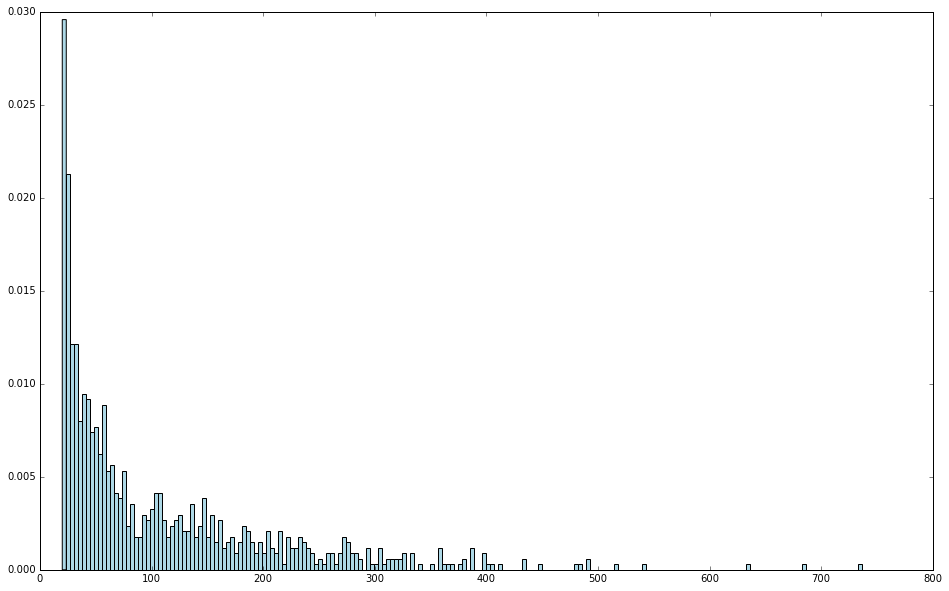

In [40]:
# and finally plot the histogram
user_ratings_byuser_local = user_ratings_byuser.map(lambda kv: kv[1]).collect()
hist(user_ratings_byuser_local, bins=200, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

## Filling in Bad or Missing Values

Missing values and outliers are also common and can be dealt with in a manner similar to bad data. Overall, the broad options are as follows:

__Filter out or remove records with bad or missing values__: This is sometimes unavoidable; however, this means losing the good part of a bad or missing record.

__Fill in bad or missing data:__ We can try to assign a value to bad or missing data based on the rest of the data we have available. Approaches can include assigning a zero value, assigning the global mean or median, interpolating nearby or similar data points (usually, in a time-series dataset), and so on. Deciding on the correct approach is often a tricky task and depends on the data, situation, and one's own experience.

__Apply robust techniques to outliers:__ The main issue with outliers is that they might be correct values, even though they are extreme. They might also be errors. It is often very difficult to know which case you are dealing with. Outliers can also be removed or filled in, although fortunately, there are statistical techniques (such as robust regression) to handle outliers and extreme values.

__Apply transformations to potential outliers:__ Another approach for outliers or extreme values is to apply transformations, such as a logarithmic or Gaussian kernel transformation, to features that have potential outliers, or display large ranges of potential values. These types of transformations have the effect of dampening the impact of large changes in the scale of a variable and turning a nonlinear relationship into one that is linear.

In [42]:
years_pre_processed = movie_fields.map(lambda fields: fields[2]) \
    .map(lambda x: convert_year(x)) \
    .filter(lambda yr: yr != 1900) \
    .collect()
years_pre_processed_arr = np.array(years_pre_processed)   
# first we compute the mean and median year of release, without the 'bad' data point
mean_year = np.mean(years_pre_processed_arr[years_pre_processed_arr!=1900])
median_year = np.median(years_pre_processed_arr[years_pre_processed_arr!=1900])
idx_bad_data = np.where(years_pre_processed_arr==1900)[0]#[0]
years_pre_processed_arr[idx_bad_data] = median_year
print ("Mean year of release: %d" % mean_year)
print ("Median year of release: %d" % median_year)
print ("Index of '1900' after assigning median: %s" % np.where(years_pre_processed_arr == 1900)[0])

Mean year of release: 1989
Median year of release: 1995
Index of '1900' after assigning median: []


##Feature Extraction

### Categorical Features: _1-of-k_ Encoding of User Occupation

Once we have completed the initial exploration, processing, and cleaning of our data, we are ready to get down to the business of extracting actual features from the data, with which our machine learning model can be trained.

__Features__ refer to the __variables that we use to train our model__. Each row of data contains various information that we would like to extract into a training example. Almost all machine learning models ultimately work on numerical representations in the form of a vector; hence, we need to convert raw data into numbers.

Features broadly fall into a few categories, which are as follows:

__Numerical features:__ These features are typically real or integer numbers, for example, the user age that we used in an example earlier.

__Categorical features:__ These features refer to variables that can take one of a set of possible states at any given time. Examples from our dataset might include a user's gender or occupation or movie categories.

__Text features:__ These are features derived from the text content in the data, for example, movie titles, descriptions, or reviews.

__Other features:__ Most other types of features are ultimately represented numerically. For example, images, video, and audio can be represented as sets of numerical data. Geographical locations can be represented as latitude and longitude or geohash data.

We can then assign index values to each possible occupation in turn:

In [43]:
all_occupations = user_fields.map(lambda fields: fields[3]).distinct().collect()
all_occupations.sort()
# create a new dictionary to hold the occupations, and assign the "1-of-k" indexes
idx = 0
all_occupations_dict = {}
for o in all_occupations:
    all_occupations_dict[o] = idx
    idx +=1
# try a few examples to see what "1-of-k" encoding is assigned
print ("Encoding of 'doctor': %d" % all_occupations_dict['doctor'])
print ("Encoding of 'programmer': %d" % all_occupations_dict['programmer'])

Encoding of 'doctor': 2
Encoding of 'programmer': 14


Finally, we can encode the value of programmer. We will start by creating a numpy array of a length that is equal to the number of possible occupations (k in this case) and filling it with zeros. We will use the zeros function of numpy to create this array.

We will then extract the index of the word programmer and assign a value of 1 to the array value at this index:

In [44]:
# create a vector representation for "programmer" and encode it into a binary vector
K = len(all_occupations_dict)
binary_x = np.zeros(K)
k_programmer = all_occupations_dict['programmer']
binary_x[k_programmer] = 1
#This will give us the resulting binary feature vector of length 21:
print ("Binary feature vector: %s" % binary_x)
print ("Length of binary vector: %d" % K)

Binary feature vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Length of binary vector: 21


### Transforming Timestamps into Categorical Features

To illustrate how to derive categorical features from numerical data, we will use the times of the ratings given by users to movies. These are in the form of Unix timestamps. We can use Python's datetime module to extract the date and time from the timestamp and, in turn, extract the hour of the day. This will result in an RDD of the hour of the day for each rating.

We will need a function to extract a datetime representation of the rating timestamp (in seconds); we will create this function now:

In [45]:
# a function to extract the timestamps (in seconds) from the dataset
def extract_datetime(ts):
    import datetime
    return datetime.datetime.fromtimestamp(ts)
# First, we will use a map transformation to extract the timestamp field, 
# converting it to a Python int datatype. 
# We will then apply our extract_datetime function to each 
# timestamp and extract the hour from the resulting datetime object:    
timestamps = rating_data.map(lambda fields: int(fields[3]))
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)
hour_of_day.take(5)

[16, 21, 8, 6, 6]

In [47]:
# a function for assigning "time-of-day" bucket given an hour of the day
def assign_tod(hr):
    times_of_day = {
                'morning' : range(7, 12),
                'lunch' : range(12, 14),
                'afternoon' : range(14, 18),
                'evening' : range(18, 23),
                'night' : range(23, 7)
                }
    for k, v in times_of_day.items():
        if hr in v: 
            return k

# now apply the "time of day" function to the "hour of day" RDD
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
time_of_day.take(5)

['afternoon', 'evening', 'morning', None, None]

We have now transformed the timestamp variable (which can take on thousands of values and is probably not useful to a model in its raw form) into hours (taking on 24 values) and then into a time of day (taking on five possible values). Now that we have a categorical feature, we can use the same 1-of-k encoding method outlined earlier to generate a binary feature vector.

### Simple Text Feature Extraction

There are numerous ways of dealing with text, and the field of natural language processing is dedicated to processing, representing, and modeling textual content. A full treatment is beyond the scope of this book, but we will introduce a simple and standard approach for text-feature extraction; this approach is known as the bag-of-words representation.

The bag-of-words approach treats a piece of text content as a set of the words, and possibly numbers, in the text (these are often referred to as terms). The process of the bag-of-words approach is as follows:

__Tokenization:__ First, some form of tokenization is applied to the text to split it into a set of tokens (generally words, numbers, and so on). An example of this is simple whitespace tokenization, which splits the text on each space and might remove punctuation and other characters that are not alphabetical or numerical.

__Stop word removal:__ Next, it is usual to remove very common words such as "the", "and", and "but" (these are known as stop words).

__Stemming:__ The next step can include stemming, which refers to taking a term and reducing it to its base form or stem. A common example is plural terms becoming singular (for example, dogs becomes dog and so on). There are many approaches to stemming, and text-processing libraries often contain various stemming algorithms.

__Vectorization:__ The final step is turning the processed terms into a vector representation. The simplest form is, perhaps, a binary vector representation, where we assign a value of one if a term exists in the text and zero if it does not. This is essentially identical to the categorical 1-of-k encoding we encountered earlier. Like 1-of-k encoding, this requires a dictionary of terms mapping a given term to an index number. As you might gather, there are potentially millions of individual possible terms (even after stop word removal and stemming). Hence, it becomes critical to use a sparse vector representation where only the fact that a term is present is stored, to save memory and disk space as well as compute time.

In [49]:
# we define a function to extract just the title from the raw movie title, 
# removing the year of release
def extract_title(raw):
    import re
    grps = re.search("\((\w+)\)", raw)    # this regular expression finds the non-word (numbers) between parentheses
    if grps:
        return raw[:grps.start()].strip() # we strip the trailing whitespace from the title
    else:
        return raw

# first lets extract the raw movie titles from the movie fields
raw_titles = movie_fields.map(lambda fields: fields[1])
# next, we strip away the "year of release" to leave us with just the title text
# let's test our title extraction function on the first 5 titles
for raw_title in raw_titles.take(5):
    print (extract_title(raw_title))

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat


In [50]:
# ok that looks good! let's apply it to all the titles
movie_titles = raw_titles.map(lambda m: extract_title(m))
# next we tokenize the titles into terms. We'll use simple whitespace tokenization
title_terms = movie_titles.map(lambda t: t.split(" "))
print (title_terms.take(5))

[['Toy', 'Story'], ['GoldenEye'], ['Four', 'Rooms'], ['Get', 'Shorty'], ['Copycat']]


In [51]:
# next we would like to collect all the possible terms, in order to build out dictionary of term <-> index mappings
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()
# create a new dictionary to hold the terms, and assign the "1-of-k" indexes
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx +=1
num_terms = len(all_terms_dict)
print ("Total number of terms: %d" % num_terms)
print ("Index of term 'Dead': %d" % all_terms_dict['Dead'])
print ("Index of term 'Rooms': %d" % all_terms_dict['Rooms'])

Total number of terms: 2645
Index of term 'Dead': 898
Index of term 'Rooms': 268


In [52]:
# we could also use Spark's 'zipWithIndex' RDD function to create the term dictionary
all_terms_dict2 = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()
print ("Index of term 'Dead': %d" % all_terms_dict2['Dead'])
print ("Index of term 'Rooms': %d" % all_terms_dict2['Rooms'])

Index of term 'Dead': 898
Index of term 'Rooms': 268


In [53]:
# this function takes a list of terms and encodes it as a scipy sparse vector using an approach 
# similar to the 1-of-k encoding
def create_vector(terms, term_dict):
    from scipy import sparse as sp
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x
all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda terms: create_vector(terms, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

## Normalizing Features

### Scaling the Norm of Vectors

In [54]:
np.random.seed(42)
x = np.random.randn(10)
norm_x_2 = np.linalg.norm(x)
normalized_x = x / norm_x_2
print ("x:\n%s" % x)
print ("2-Norm of x: %2.4f" % norm_x_2)
print ("Normalized x:\n%s" % normalized_x)
print ("2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x))

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


 ### Scaling the Norm of Vectors with MLlib's Normalizer

In [55]:
from pyspark.mllib.feature import Normalizer
normalizer = Normalizer()
vector = sc.parallelize([x])
normalized_x_mllib = normalizer.transform(vector).first().toArray()

print ("x:\n%s" % x)
print ("2-Norm of x: %2.4f" % norm_x_2)
print ("Normalized x MLlib:\n%s" % normalized_x_mllib)
print ("2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib))

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000
